In [73]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import utils
import dataloaders
import torchvision
from trainer import Trainer
torch.random.manual_seed(0)
np.random.seed(0)

### Dataset

In [74]:
# Load the dataset and print some stats
batch_size = 64

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
      f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")

The tensor containing the images has shape: torch.Size([64, 1, 28, 28]) (batch size, number of color channels, height, width)
	The maximum value in the image is 1.0, minimum: 0.0


In [75]:
def create_model(hidden=False):
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    if hidden:

        model = nn.Sequential(
            nn.Flatten(),  # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
            nn.Linear(28*28*1, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
            # No need to include softmax, as this is already combined in the loss function
        )
    else:
        model = nn.Sequential(
            nn.Flatten(),  # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
            nn.Linear(28*28*1, 10)
        )
            # No need to include softmax, as this is already combined in the loss function

    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model


model = create_model()


In [76]:
# Test if the model is able to do a single forward pass
example_images = utils.to_cuda(example_images)
output = model(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10) # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"

Output shape: torch.Size([64, 10])


### Hyperparameters & Loss function

In [77]:
# Hyperparameters
learning_rate = .0192
num_epochs = 5


# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)

### Train model

## Task A

First, we will train the model without normalization.

In [88]:
torch.random.manual_seed(0)
np.random.seed(0)

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
dataloader_train, dataloader_test = dataloaders.load_dataset(
    batch_size, image_transform)

model = create_model()

# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)

In [89]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict, test_loss_dict = trainer.train(num_epochs)

Training epoch 4: 100%|██████████| 938/938 [00:11<00:00, 82.25it/s]


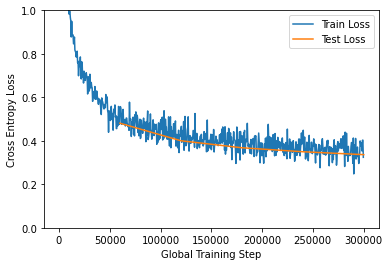

Final Test loss: 0.33638823167628545. Final Test accuracy: 0.9083


In [90]:
# We can now plot the training loss with our utility script

# Plot loss
utils.plot_loss(train_loss_dict, label="Train Loss")
utils.plot_loss(test_loss_dict, label="Test Loss")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4a_original.png")

plt.show()

torch.save(model.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

### Normalization 
We now normalize the data before training the model.

In [93]:
torch.random.manual_seed(0)
np.random.seed(0)

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5),
])
dataloader_train, dataloader_test = dataloaders.load_dataset(
    batch_size, image_transform)
model = create_model()
# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)

In [94]:
trainer = Trainer(
    model=model,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer
)
train_loss_dict_A, test_loss_dict_A = trainer.train(
    num_epochs)


Training epoch 4: 100%|██████████| 938/938 [00:13<00:00, 70.75it/s]


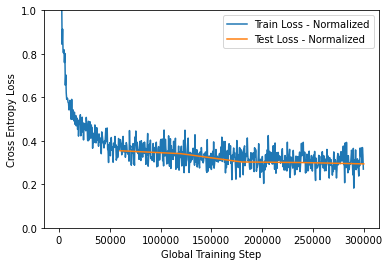

Final Test loss: 0.293984672944447. Final Test accuracy: 0.9164


In [95]:
# We can now plot the training loss with our utility script

# Plot loss
utils.plot_loss(train_loss_dict_A, label="Train Loss - Normalized")
utils.plot_loss(test_loss_dict_A, label="Test Loss - Normalized")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4a_normalized.png")

plt.show()

torch.save(model.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")


## Task B

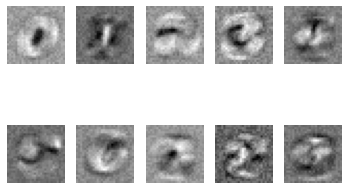

In [37]:
weight = list(model.children())[1].weight.cpu().data


for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(weight[i].reshape(28,28), cmap="gray")
    plt.axis('off')

## Task C

In [38]:
torch.random.manual_seed(0)
np.random.seed(0)
learning_rate = 1.0

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5),
])
dataloader_train, dataloader_test = dataloaders.load_dataset(
    batch_size, image_transform)
model = create_model()
# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)


In [39]:
trainer = Trainer(
    model=model,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer
)
train_loss_dict_C, test_loss_dict_C = trainer.train(
    num_epochs)


Training epoch 4: 100%|██████████| 938/938 [00:14<00:00, 65.39it/s]


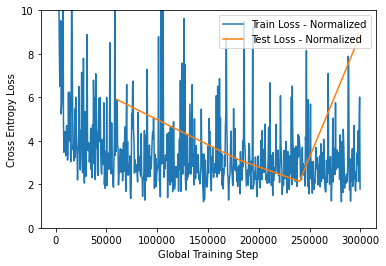

Final Test loss: 8.909797666938442. Final Test accuracy: 0.7706


In [45]:
# We can now plot the training loss with our utility script

# Plot loss
utils.plot_loss(train_loss_dict_C, label="Train Loss")
utils.plot_loss(test_loss_dict_C, label="Test Loss")
plt.ylim([0, 10])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4c.png")

plt.show()

torch.save(model.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

## Task D

In [98]:
torch.random.manual_seed(0)
np.random.seed(0)
learning_rate = 0.0192

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5),
])
dataloader_train, dataloader_test = dataloaders.load_dataset(
    batch_size, image_transform)
model = create_model(hidden=True)
# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)


In [99]:
trainer = Trainer(
    model=model,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer
)
train_loss_dict_D, test_loss_dict_D = trainer.train(
    num_epochs)

Training epoch 4: 100%|██████████| 938/938 [00:15<00:00, 61.76it/s]


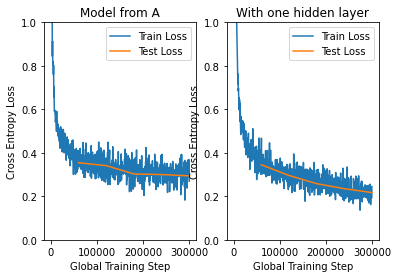

Final Test loss with hidden layer: 0.21702577218793. Final Test accuracy with hidden layer: 0.9367


<Figure size 432x288 with 0 Axes>

In [103]:
# We can now plot the training loss with our utility script

# Plot loss
plt.subplot(1,2,1)
utils.plot_loss(train_loss_dict_A, label="Train Loss")
utils.plot_loss(test_loss_dict_A, label="Test Loss")
plt.ylim([0, 1])
plt.legend()
plt.title("Model from A")
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")

plt.subplot(1,2,2)
utils.plot_loss(train_loss_dict_D, label="Train Loss")
utils.plot_loss(test_loss_dict_D, label="Test Loss")
plt.ylim([0, 1])
plt.legend()
plt.title("With one hidden layer")
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")

plt.show()
plt.savefig("image_solutions/task_4d2.png")

torch.save(model.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss with hidden layer: {final_loss}. Final Test accuracy with hidden layer: {final_acc}")

# Can we get to 100%?

Let us see how far we can get with the accuracy (hopefully without overfitting).

In [104]:
torch.random.manual_seed(0)
np.random.seed(0)
learning_rate = 0.0192
num_epochs = 20

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5),
])
dataloader_train, dataloader_test = dataloaders.load_dataset(
    batch_size, image_transform)
    
model = nn.Sequential(
    nn.Flatten(),  # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
    nn.Linear(28*28*1, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
    # No need to include softmax, as this is already combined in the loss function
)

# Transfer model to GPU memory if a GPU is available
model = utils.to_cuda(model)

# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)


In [105]:
trainer = Trainer(
    model=model,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer
)
train_loss_dict, test_loss_dict = trainer.train(
    num_epochs)

Training epoch 19: 100%|██████████| 938/938 [00:14<00:00, 65.50it/s]


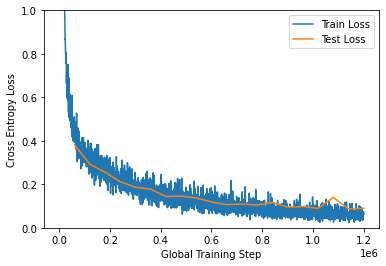

Final Test loss: 0.08977470690895029. Final Test accuracy: 0.9743


In [106]:
# We can now plot the training loss with our utility script

# Plot loss
utils.plot_loss(train_loss_dict, label="Train Loss")
utils.plot_loss(test_loss_dict, label="Test Loss")
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")

plt.show()

torch.save(model.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

We see that the model may be overfitting around step 1.1e6

In [111]:
a = input()
lst = a.strip().split(" ")
b = [float(i) for i in lst]



In [121]:
a = "Hei, på dei --- de"

b = a.strip().split("---")

c,d = b[0].strip(), b[1].strip()

In [123]:
d

'de'